# TRAPPIST-1 Follow-up

In this tutorial, we will use the discovery data for the TRAPPIST-1 planetary system to illustrate how to use `transitforecast` to prioritize follow-up windows.

In [1]:
# Import some packages we know we're going to need
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib notebook

## Load the data

First, let's load in the dataset.

In [3]:
d = pd.read_csv('trappist1_lc_flat.csv')
d

time      flux  flux_err     trend
0      2.457283e+06  0.996553       NaN  0.999392
1      2.457283e+06  0.997024       NaN  0.999422
2      2.457283e+06  0.995654       NaN  0.999356
3      2.457283e+06  1.000173       NaN  0.999391
4      2.457283e+06  1.001591       NaN  0.999457
...             ...       ...       ...       ...
12507  2.457390e+06  0.997818       NaN  1.000000
12508  2.457390e+06  0.994002       NaN  1.000000
12509  2.457390e+06  1.005075       NaN  1.000000
12510  2.457390e+06  0.994781       NaN  1.000000
12511  2.457390e+06  1.001893       NaN  1.000000

[12512 rows x 4 columns]

No flux uncertainties are provided, so we'll use the median absolute deviation of the fluxes to estimate them.

In [4]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(d.flux, scale='normal')
d.flux_err = mad
d

time      flux  flux_err     trend
0      2.457283e+06  0.996553  0.004316  0.999392
1      2.457283e+06  0.997024  0.004316  0.999422
2      2.457283e+06  0.995654  0.004316  0.999356
3      2.457283e+06  1.000173  0.004316  0.999391
4      2.457283e+06  1.001591  0.004316  0.999457
...             ...       ...       ...       ...
12507  2.457390e+06  0.997818  0.004316  1.000000
12508  2.457390e+06  0.994002  0.004316  1.000000
12509  2.457390e+06  1.005075  0.004316  1.000000
12510  2.457390e+06  0.994781  0.004316  1.000000
12511  2.457390e+06  1.001893  0.004316  1.000000

[12512 rows x 4 columns]

We could work with the data in a `pandas.DataFrame` at this point, but we'll use a `lightkurve.LightCurve` to hold the data instead so that we can take advantage of some additional functionality of that class.

In [5]:
lc = lk.LightCurve(
    time=d.time,
    flux=d.flux,
    flux_err=d.flux_err
)
lc

For example, let's take a look at the data.

<IPython.core.display.Javascript object>


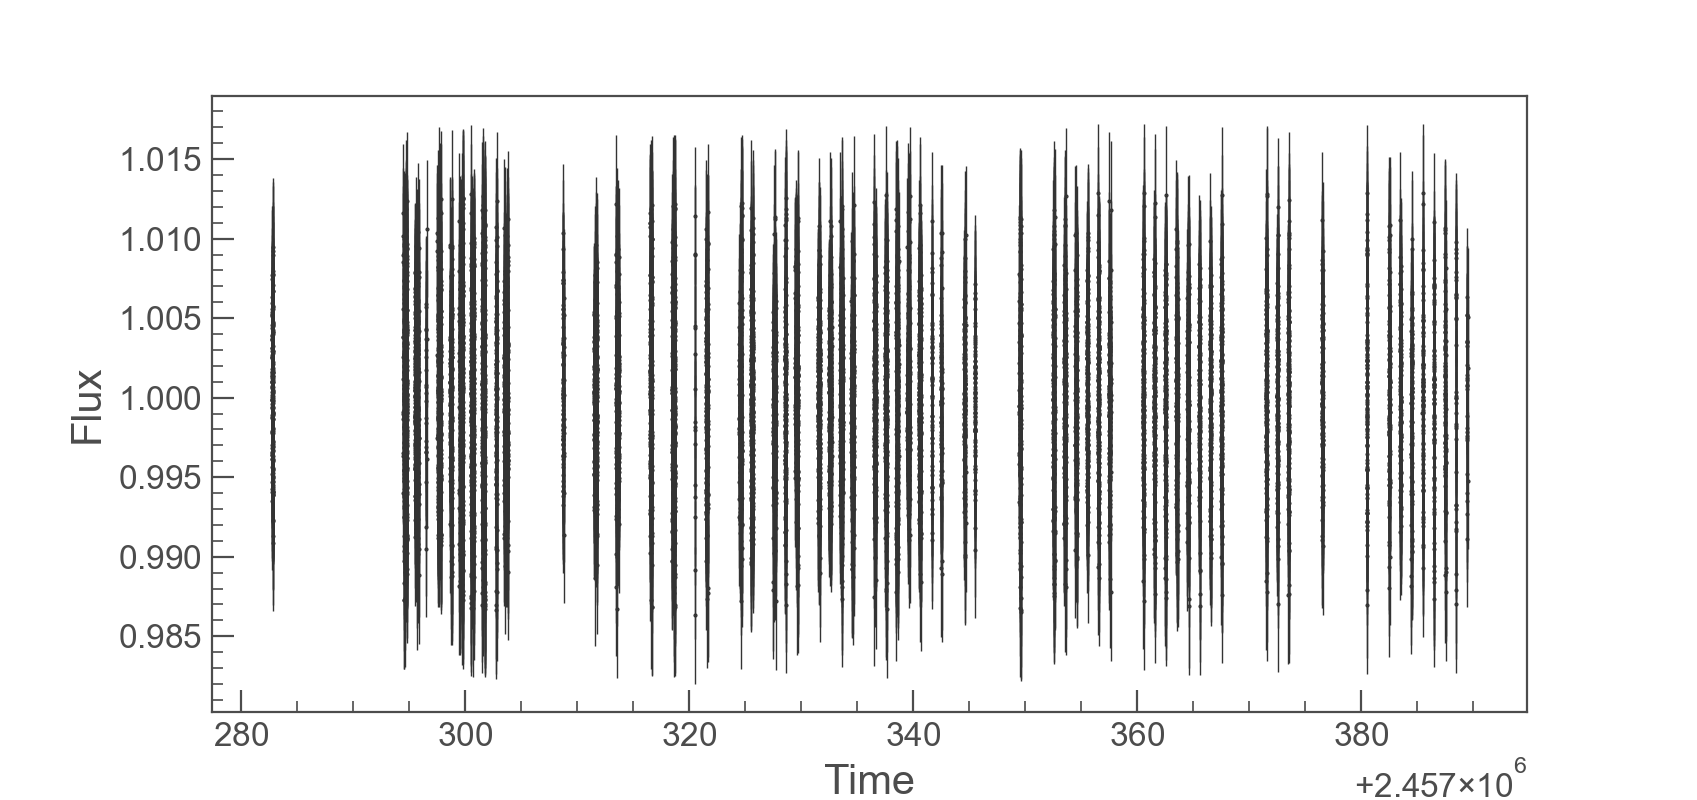

In [6]:
lc.errorbar(marker='.');

And let's phase-fold the light curve on the top `t0` and `period` returned by a `transitleastsquares` search.

<IPython.core.display.Javascript object>


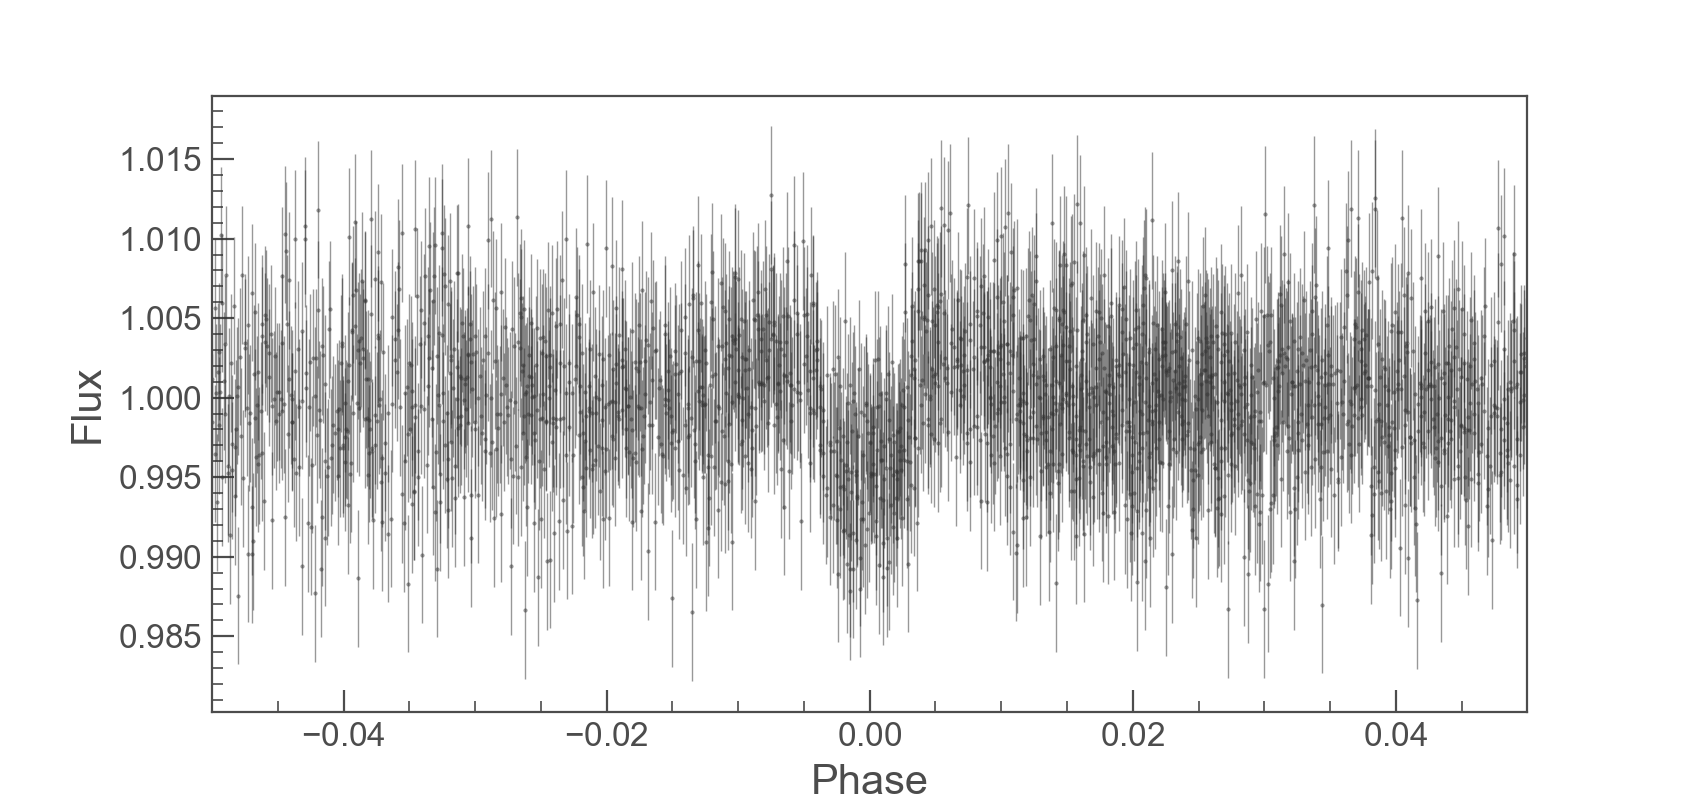

In [7]:
pri_t0 = 2457283.235
pri_p = 3.02164958340094
pri_rprs = 0.06027618

ax = lc.fold(t0=pri_t0, period=pri_p).errorbar(marker='.', alpha=0.5)
ax.set_xlim(-0.05, 0.05);

In fact, let's look at the top 5 scenarios returned by a `tls` search.

<IPython.core.display.Javascript object>


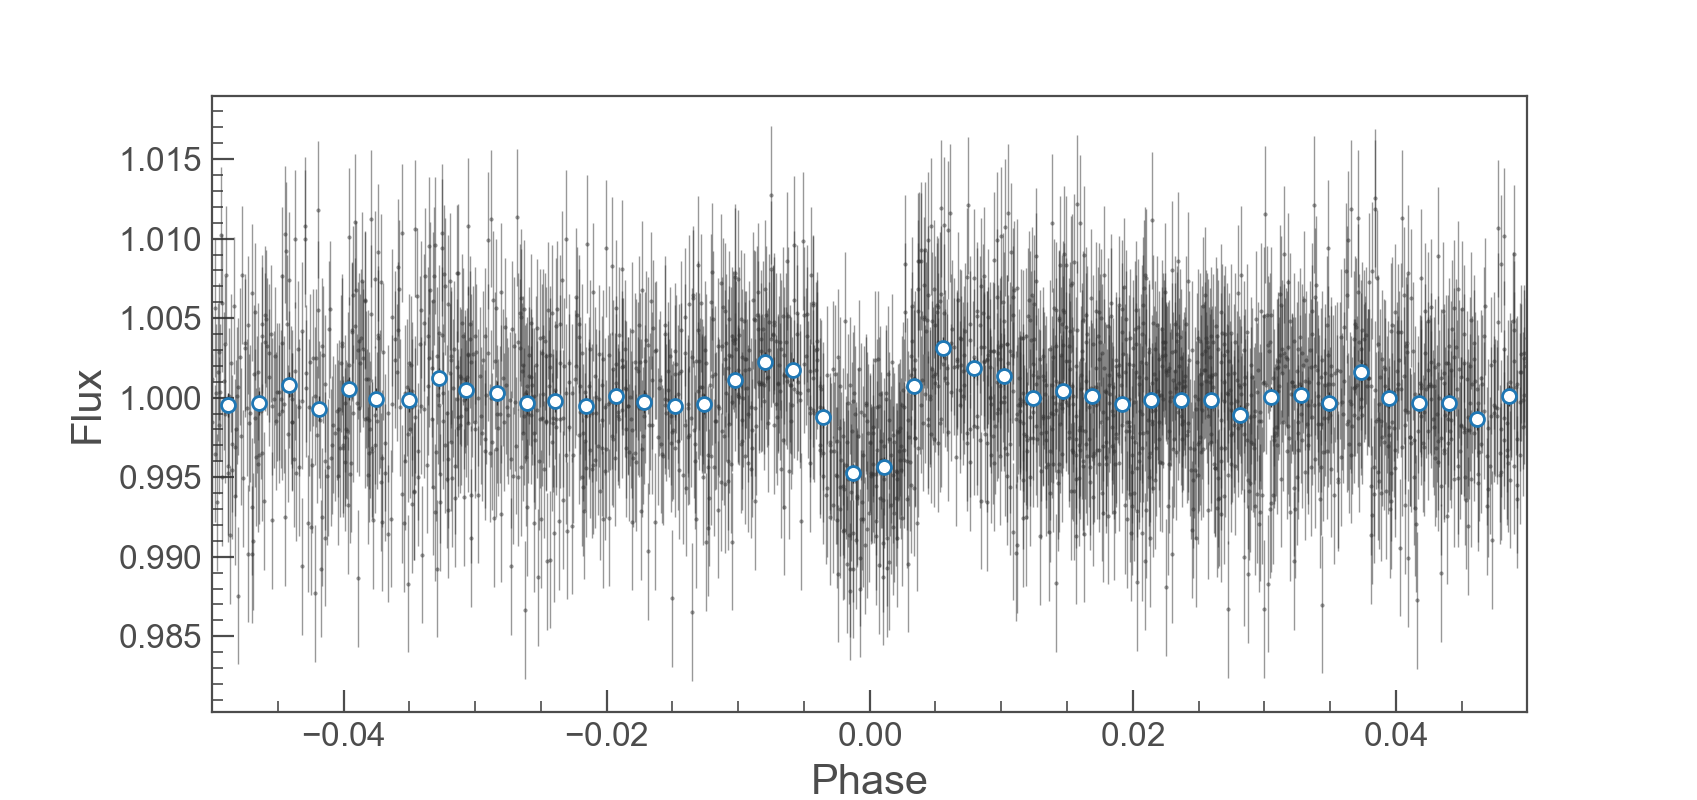

<IPython.core.display.Javascript object>


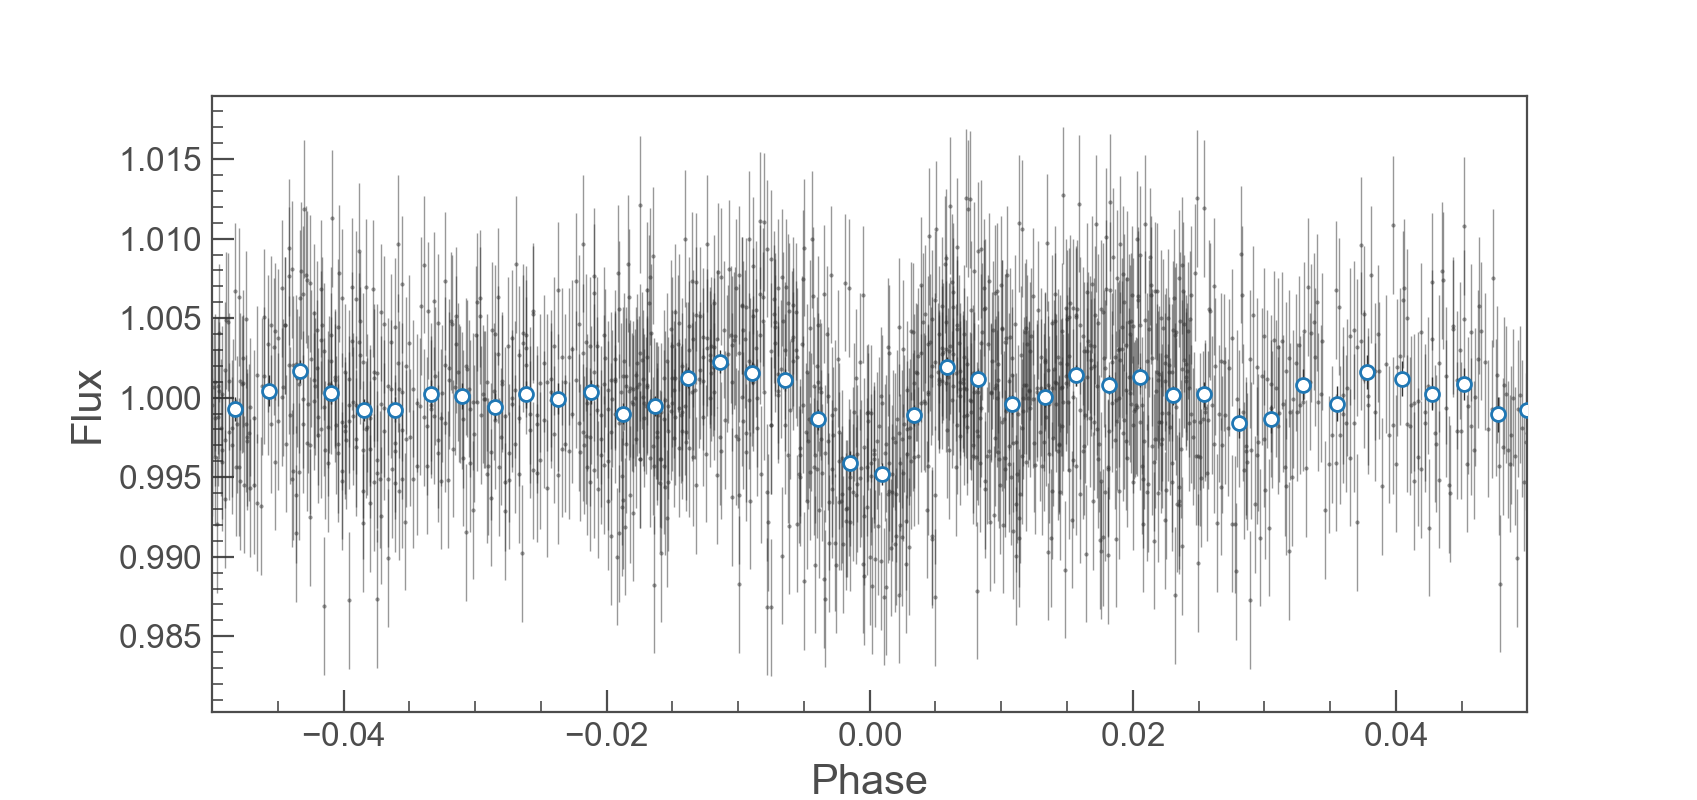

<IPython.core.display.Javascript object>


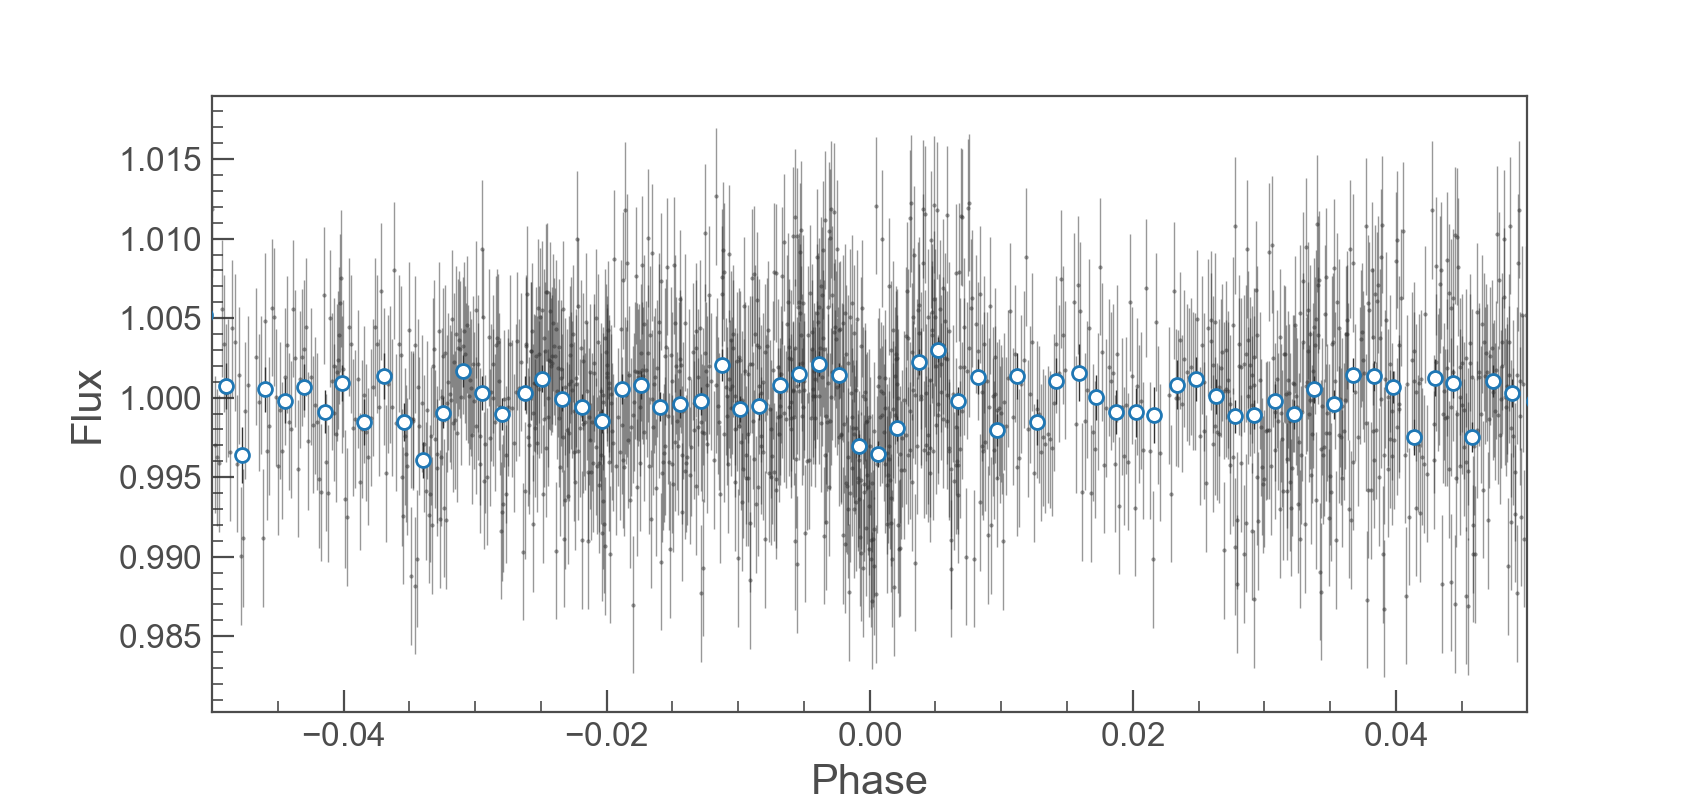

<IPython.core.display.Javascript object>


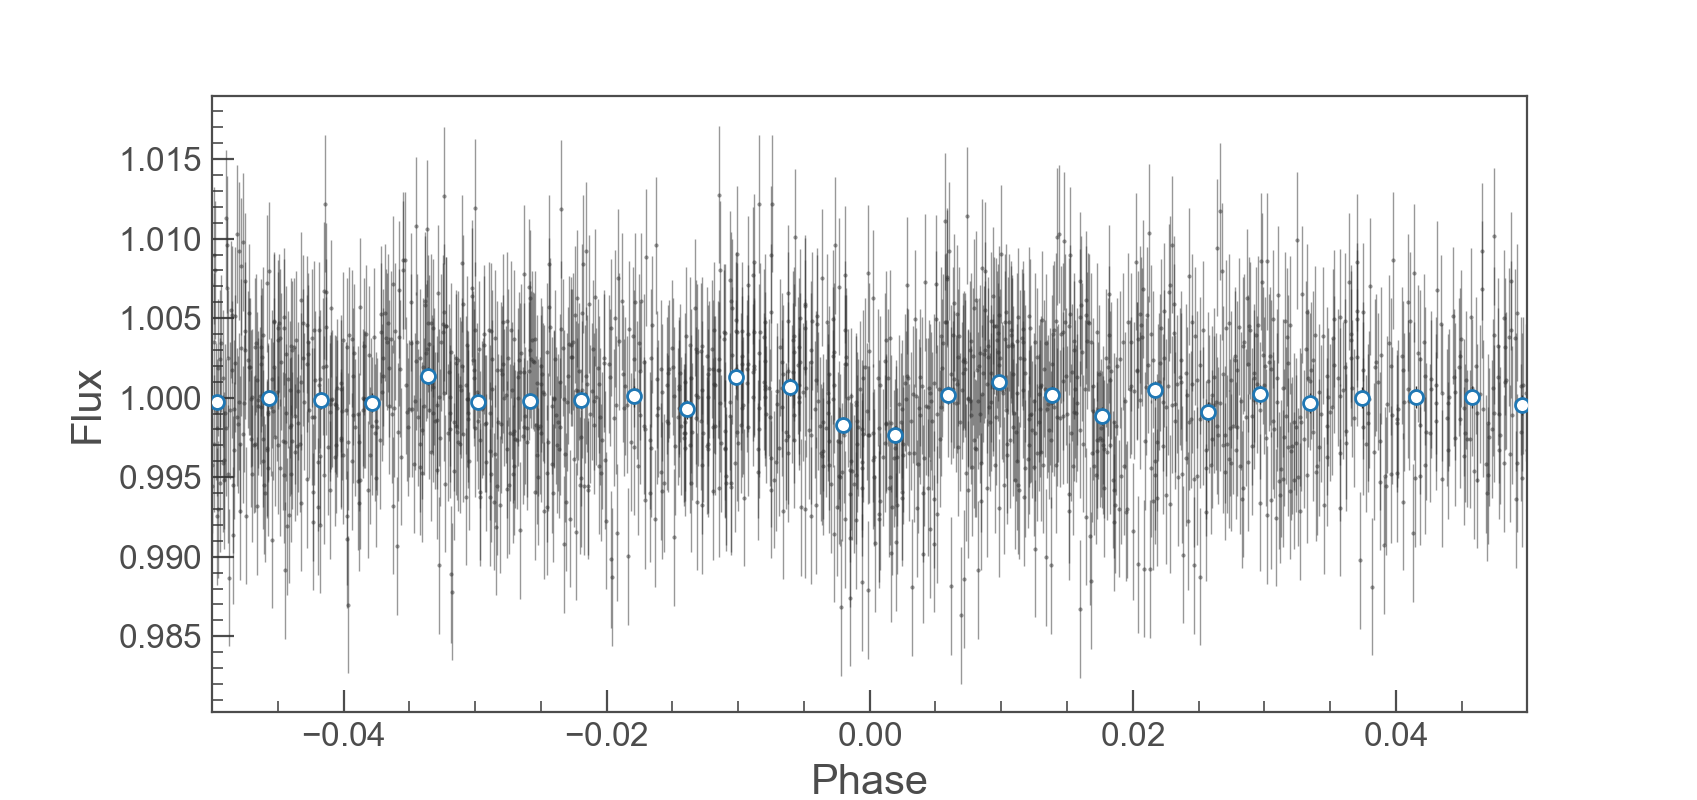

<IPython.core.display.Javascript object>


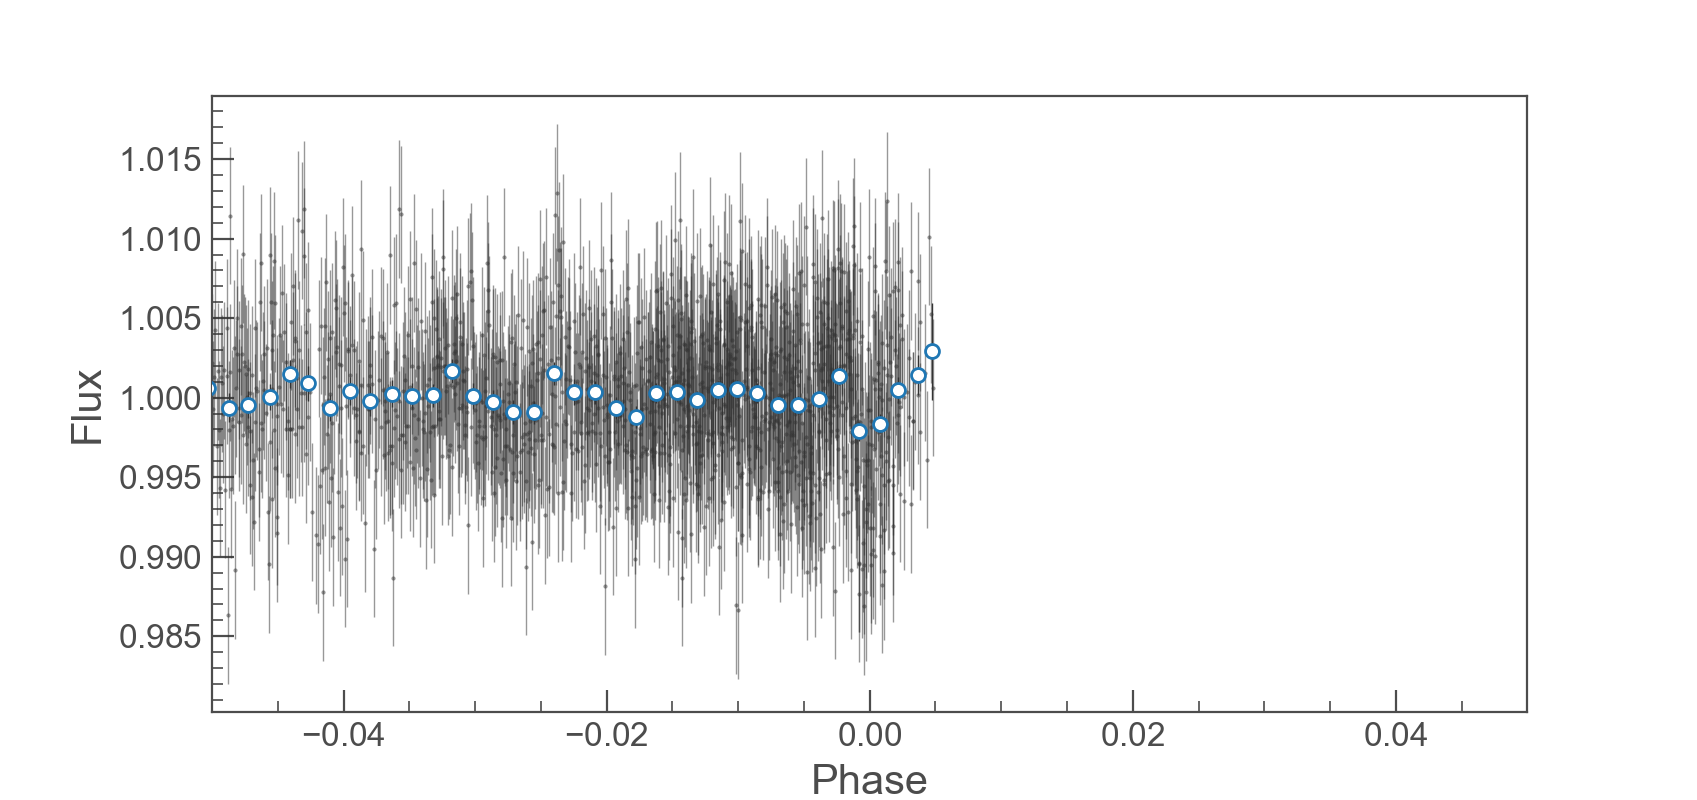

In [8]:
pri_t0s = [2457283.235, 2457282.803, 2457283.147, 2457283.696, 2457284.860] 
pri_ps = [3.02164958340094, 2.825653469, 4.615432934, 1.753996325, 4.487644045]
pri_rprss = [0.06027618, 0.059468536, 0.050877637, 0.042044128, 0.048652169]

for pri_t0, pri_p, pri_rprs in zip(pri_t0s, pri_ps, pri_rprss):
    ax = lc.fold(t0=pri_t0, period=pri_p).errorbar(marker='.', alpha=0.5)
    
    # Bin the light curve
    bins = int(pri_p/(10/(24*60)))  # 10-min bins
    binned_lc = lc.fold(t0=pri_t0, period=pri_p).bin(bins=bins)
    binned_lc.errorbar(ax=ax, marker='o', ms=5, color='C0', mfc='white', alpha=1, zorder=10)
    ax.set_xlim(-0.05, 0.05);

# MCMC Fit to Scenarios

Cool, now we'll use `transitforecast` to explore each of these scenarios with a MCMC. The goal is not to converge on a fit for each, but to explore the range of possible transit scenarios suggested by this dataset, using these TLS results as a jumping-off point.

We will generate a forecasted transit model for every accepted step in the MCMC, so we need to define our window of interest first.

In [9]:
import astropy.units as units

forecast_window = (0.5*units.yr).to(units.d).value
cadence = (2.*units.min).to(units.d).value

tforecast = lc.time.max() + np.arange(0, forecast_window, cadence)
tforecast

array([2457389.54448   , 2457389.54586889, 2457389.54725778, ...,
       2457572.16531333, 2457572.16670222, 2457572.16809111])

We also need priors for the stellar mass and radius. We can get these by querying the TESS Input Cataog via a convenience function provided by the `transitleastsquares` package.

In [10]:
import transitforecast as tf
import transitleastsquares as tls

tic_id = 278892590

# Wrapper for the tls.catalog_info() function
pri_m_star, pri_m_star_err, pri_r_star, pri_r_star_err = tf.get_priors_from_tic(tic_id)

Okay, now we have everything we need for the MCMC sampling.

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for 

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for 

optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 49852.04266252143 -> 49852.04266252146
optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for 

optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49852.04266252152 -> 49852.04266252152


<IPython.core.display.Javascript object>


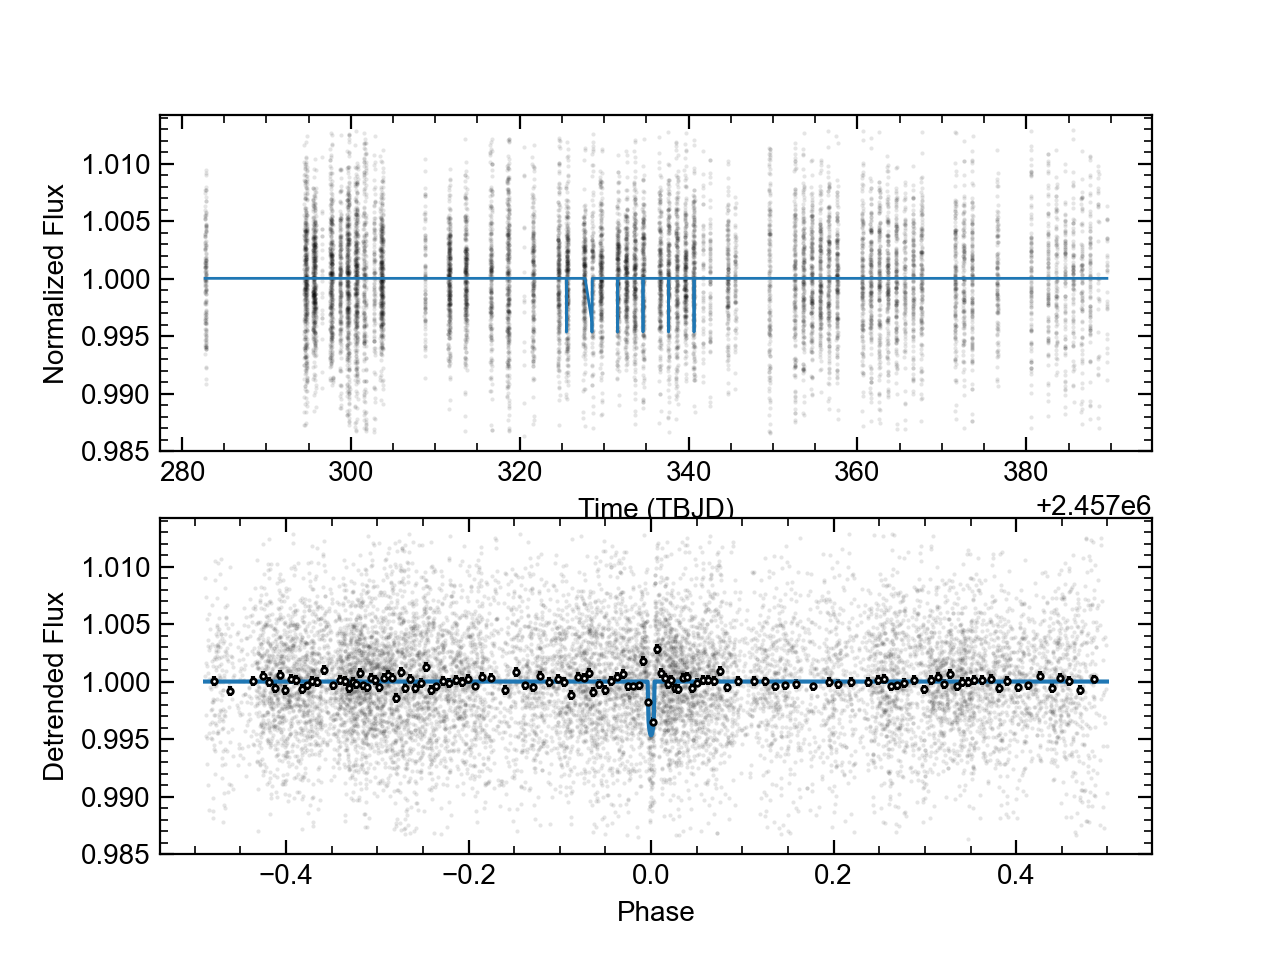

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful re

<IPython.core.display.Javascript object>


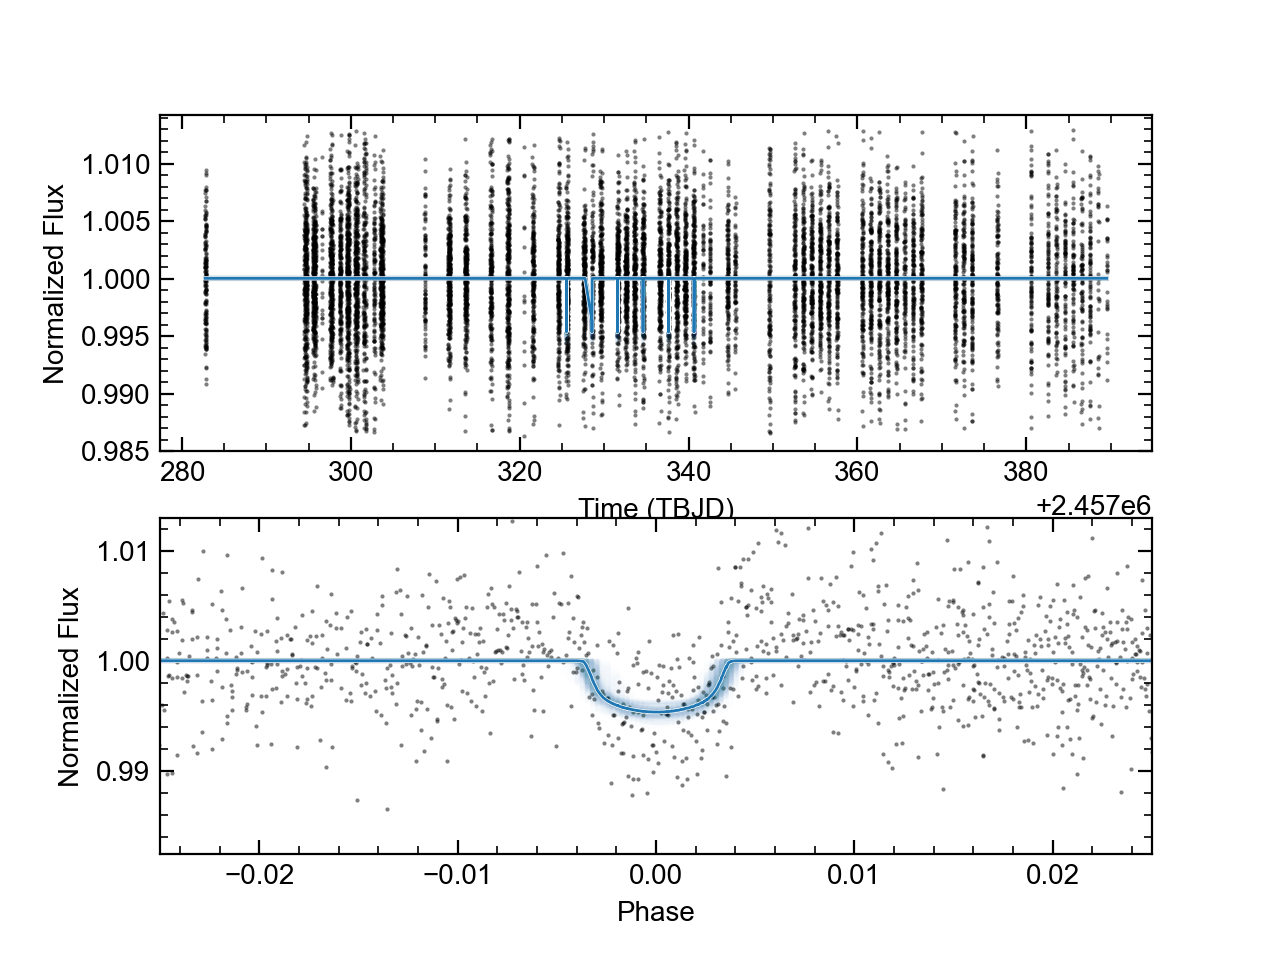

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for 

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.802753098025


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.802753098025


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.802753098025


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.80275309803


<IPython.core.display.Javascript object>


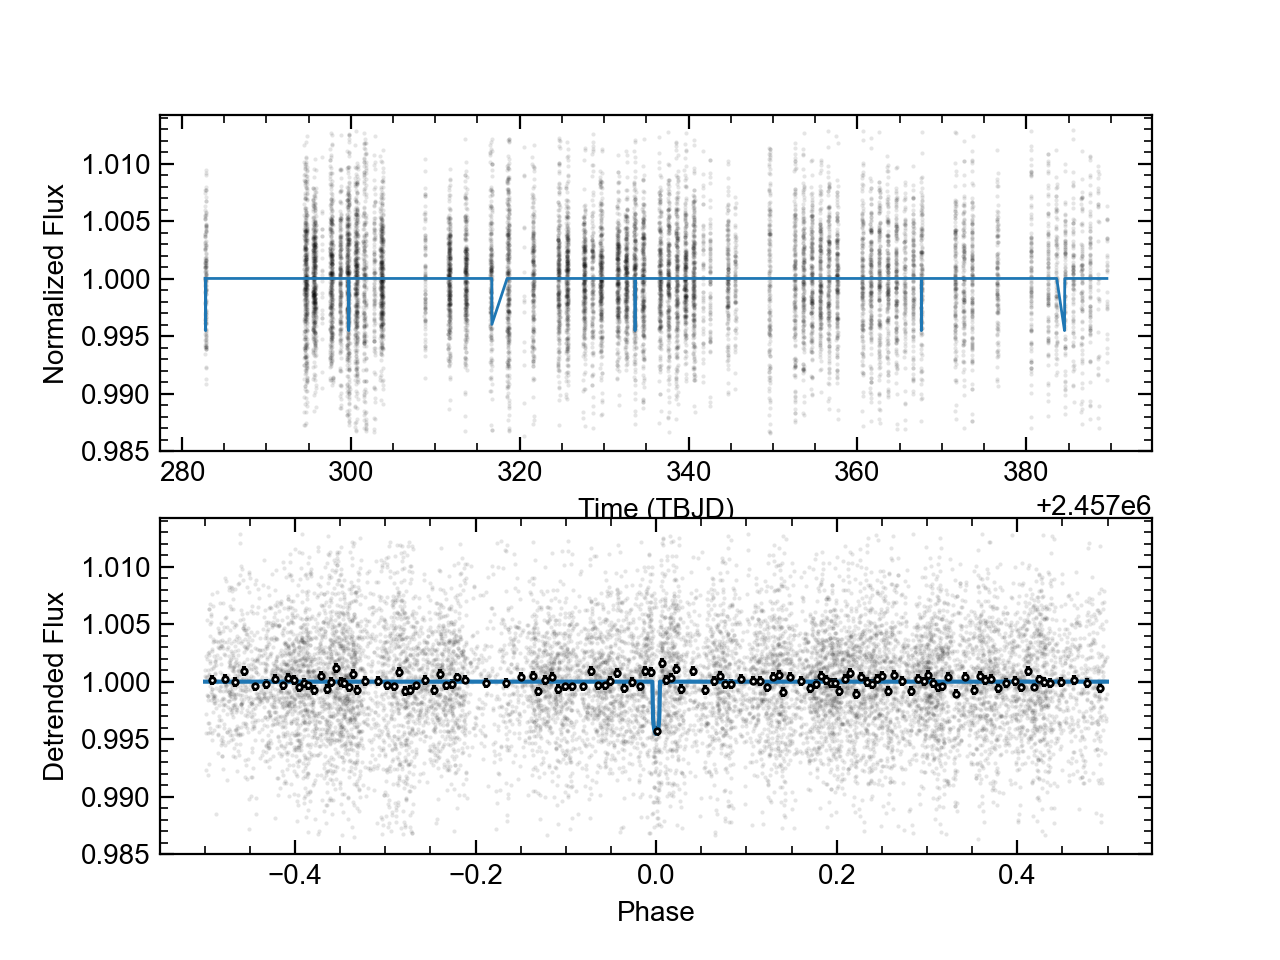

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 111 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the

<IPython.core.display.Javascript object>


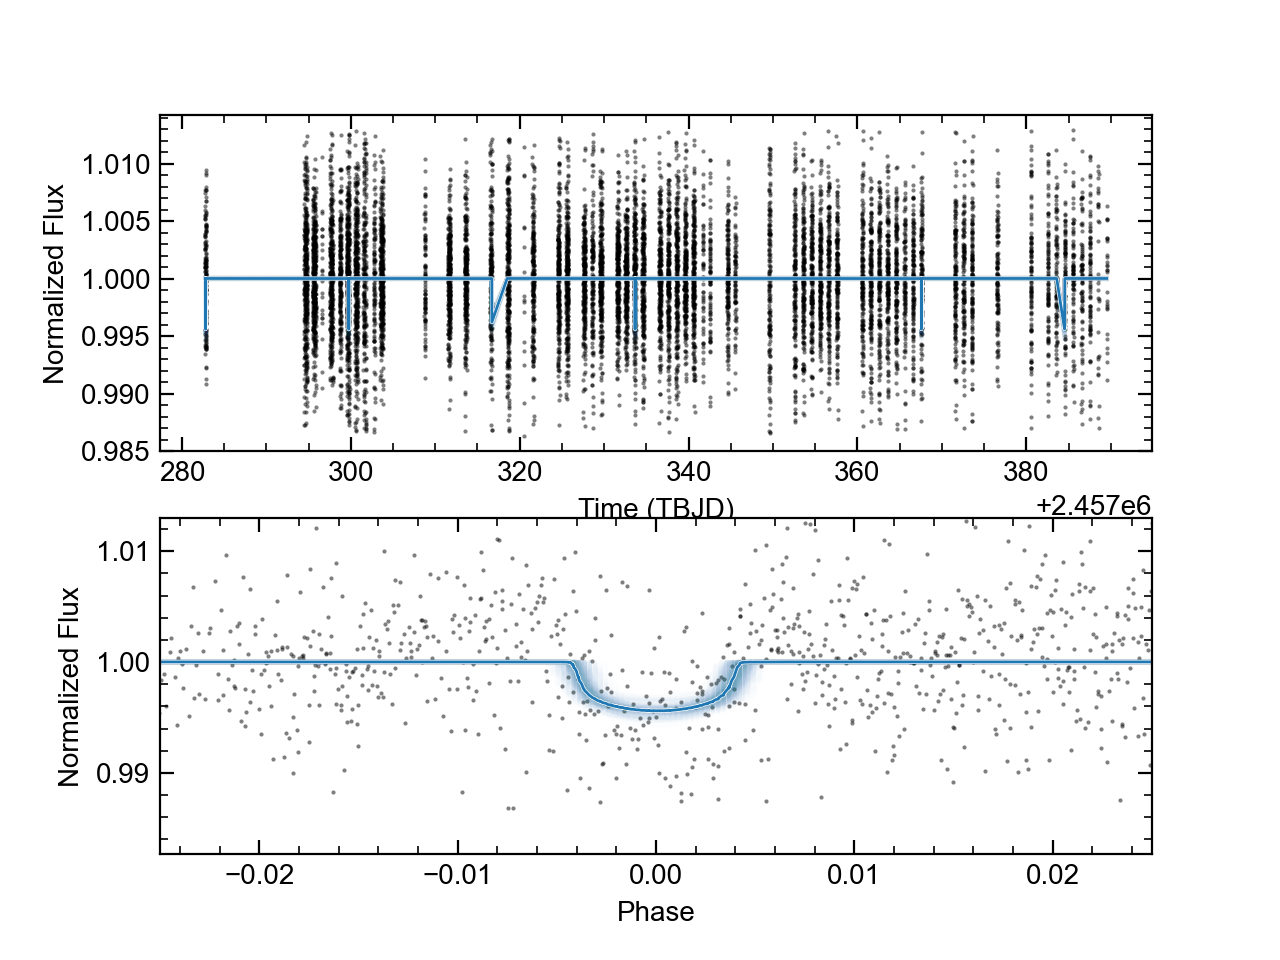

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49797.476565277684 -> 49810.4685757042


optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.4685757042 -> 49810.4685757042


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.4685757042 -> 49810.46857570421


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.46857570421 -> 49810.46857570422


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.46857570422 -> 49810.46857570422


<IPython.core.display.Javascript object>


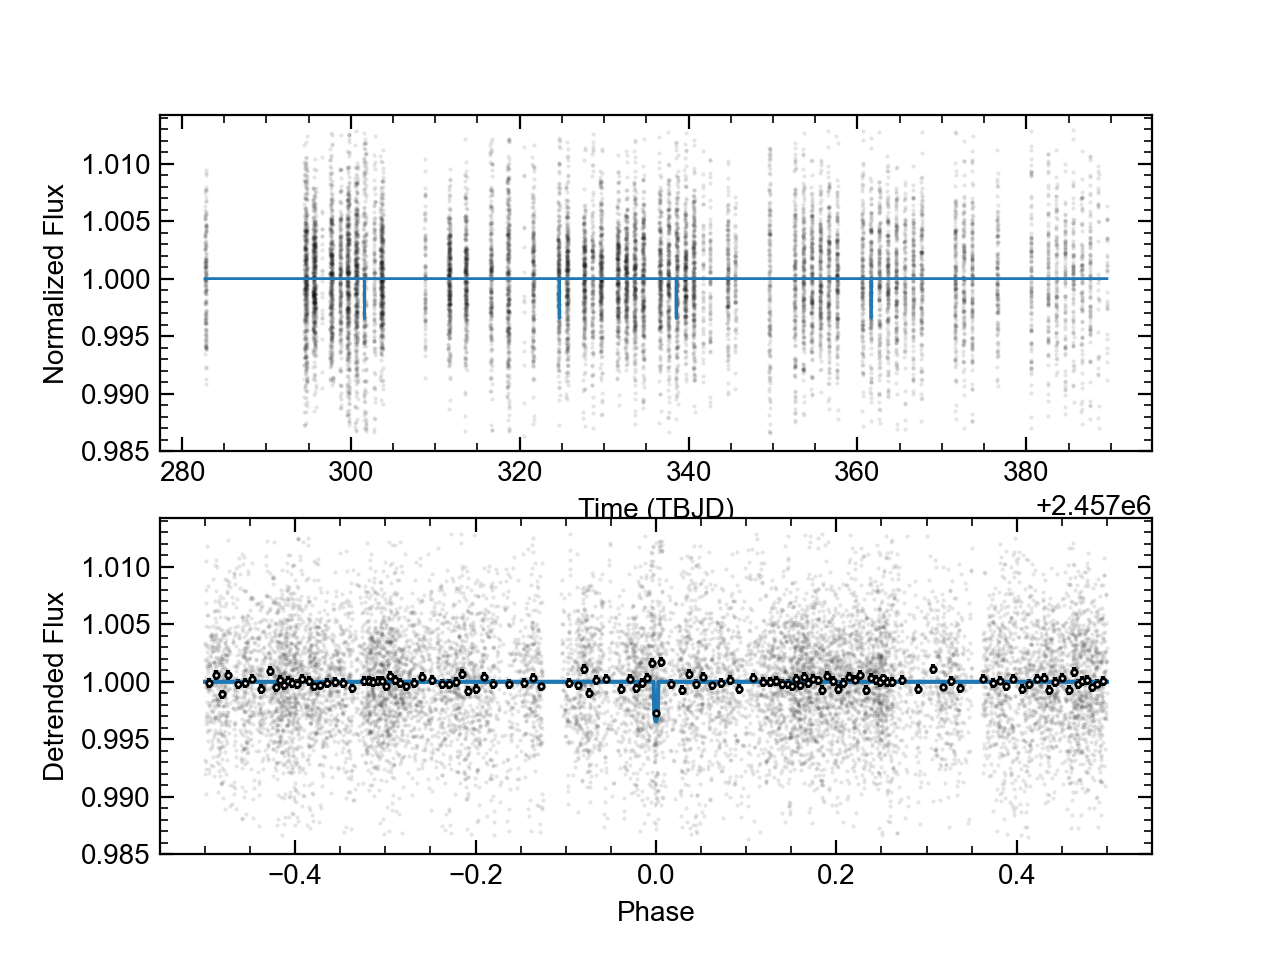

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8950653155275825, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8872204209550212, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.840185488183355, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827624154373073, but should be close to 0.95. Try 

<IPython.core.display.Javascript object>


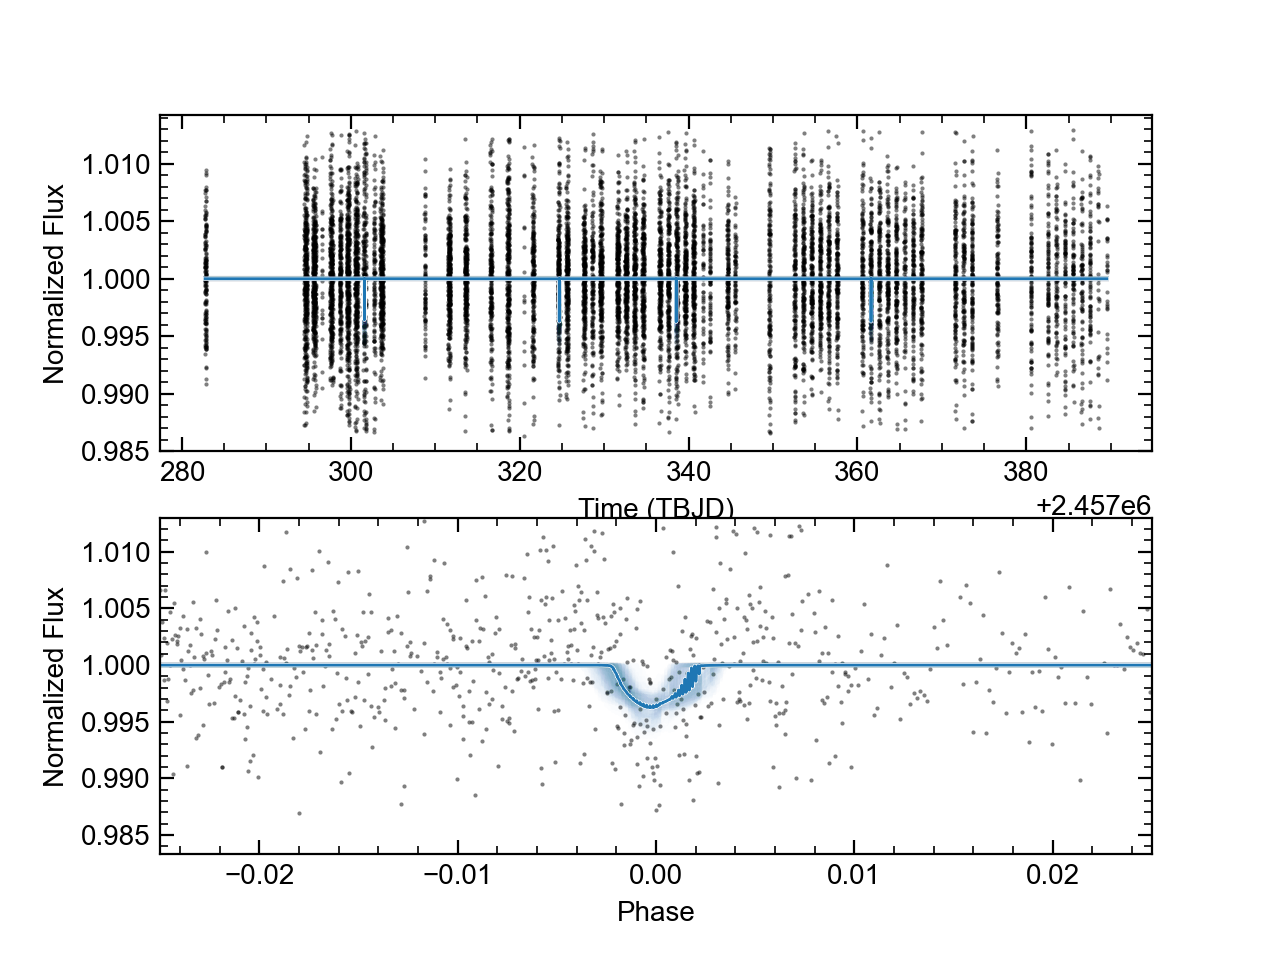

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for 

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.65949582547 -> 49804.65949582547


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.65949582547 -> 49804.65949582547


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.65949582547 -> 49804.659495825494


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.659495825494 -> 49804.659495825494


<IPython.core.display.Javascript object>


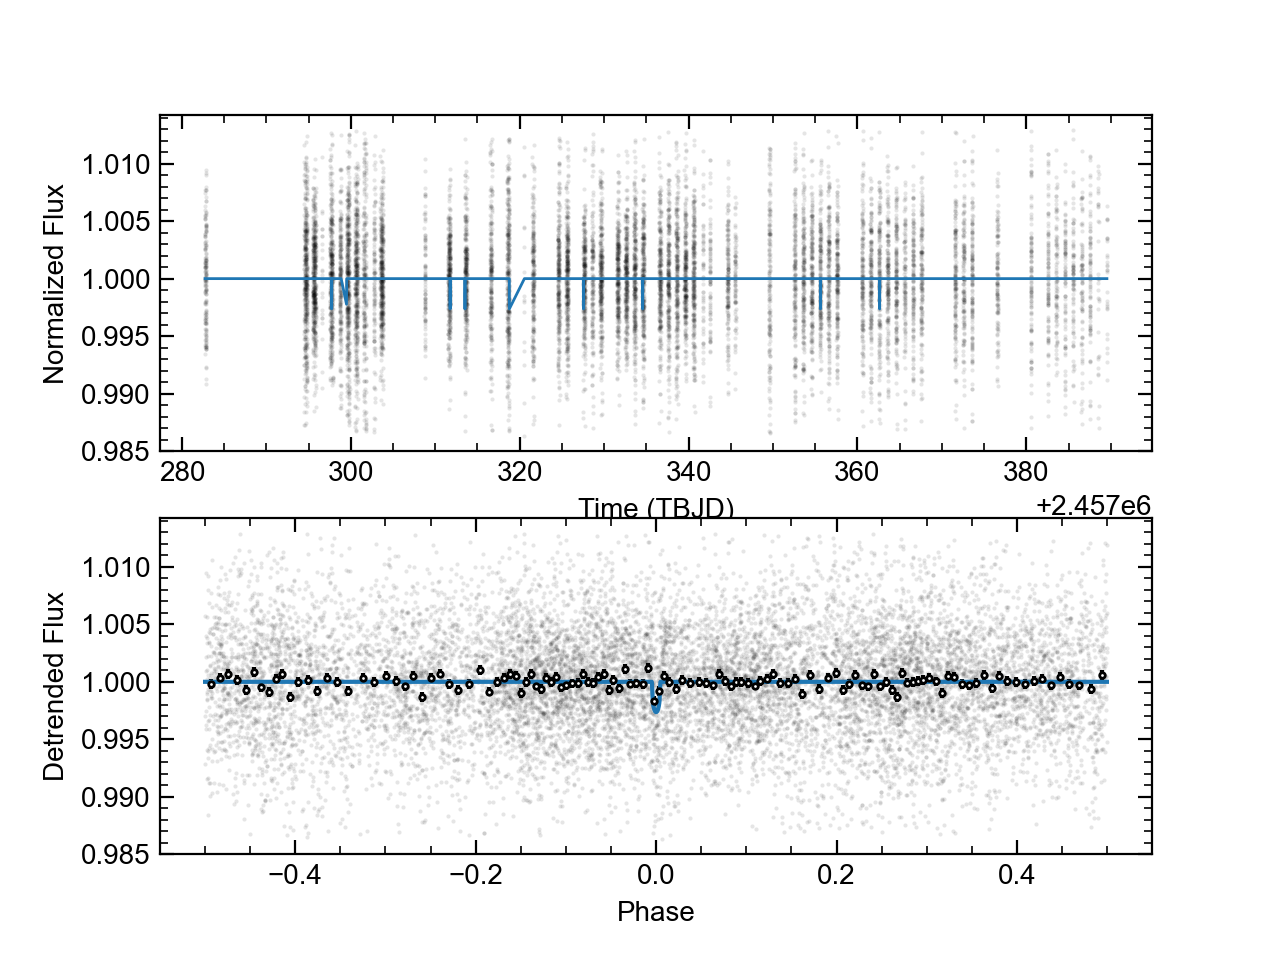

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 131 seconds.
The acceptance probability does not match the target. It is 0.8911856942496392, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8892205106300047, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the mod

<IPython.core.display.Javascript object>


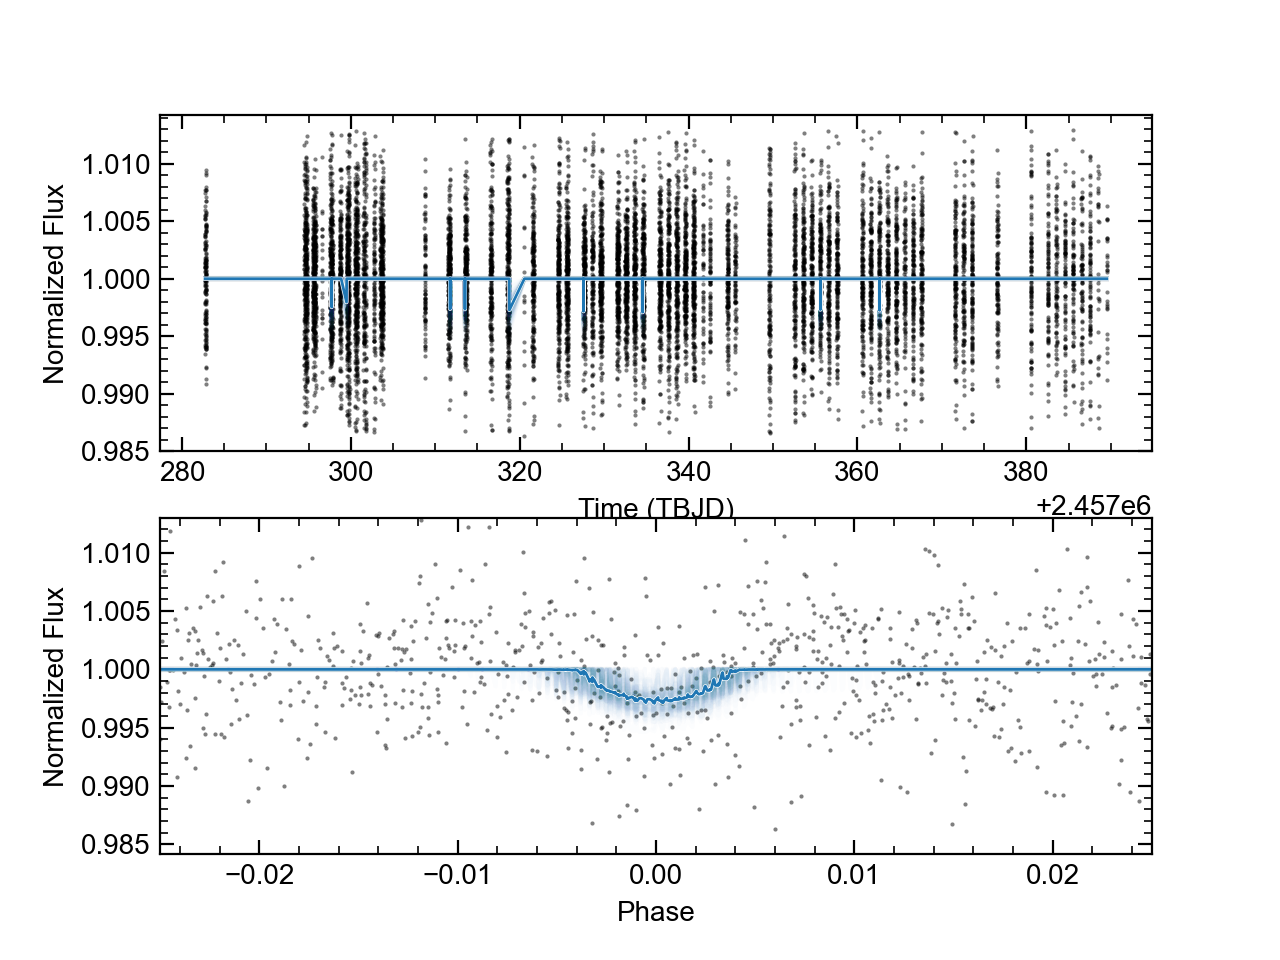

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49772.318572987955 -> 49788.99616171782


optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171782 -> 49788.99616171782


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171782 -> 49788.99616171783


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171783 -> 49788.99616171783


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171783 -> 49788.99616171783


<IPython.core.display.Javascript object>


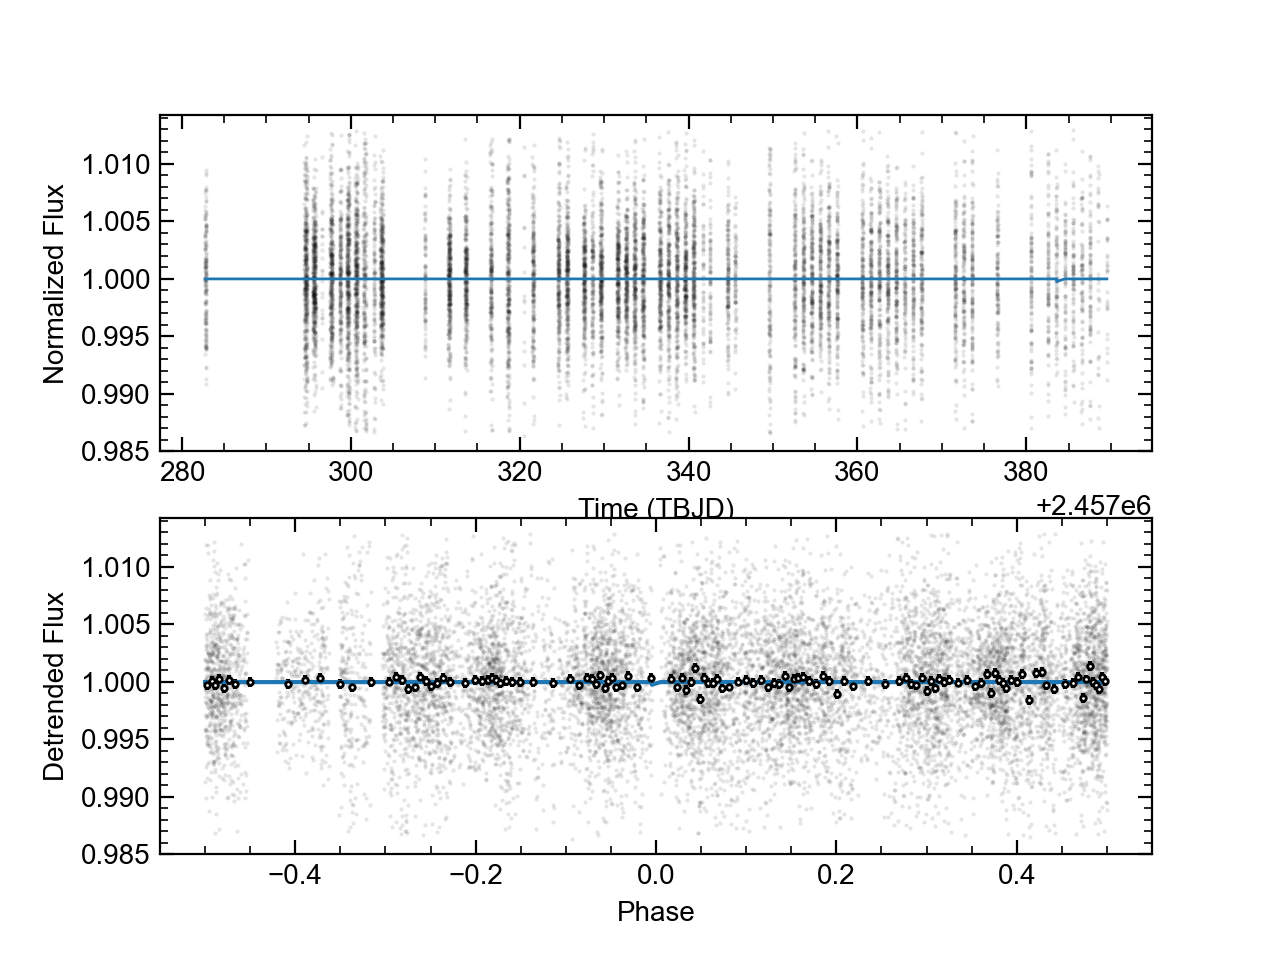

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 259 seconds.
The acceptance probability does not match the target. It is 0.7267437637090303, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4576389028481752, but should be close to 0.95. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.41889905252121545, but should be close to 0.95. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7589051173124582

<IPython.core.display.Javascript object>


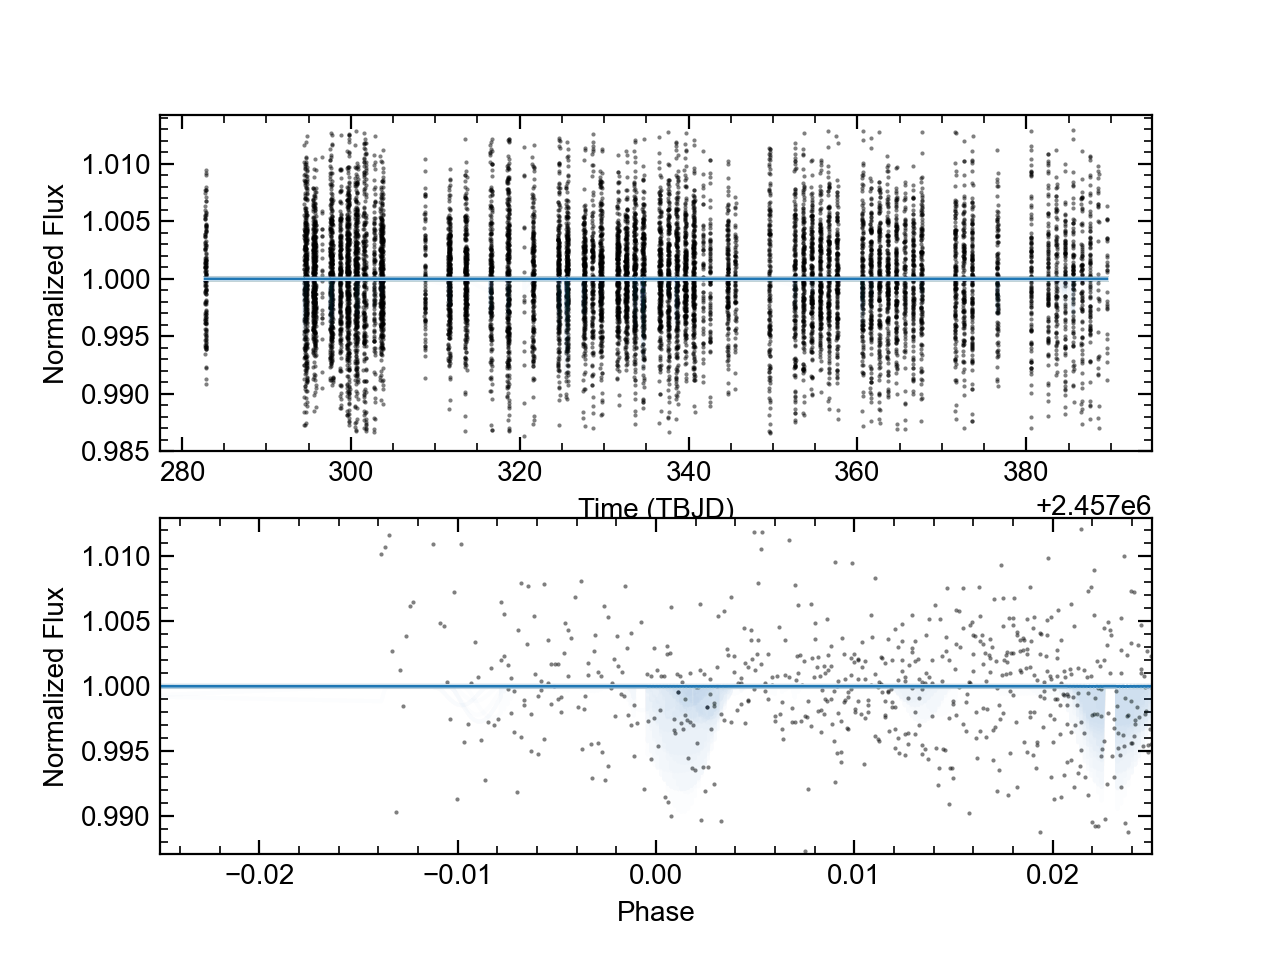

In [11]:
models = []
map_solns = []
traces = []
for i, (pri_t0, pri_p, pri_rprs) in enumerate(zip(pri_t0s, pri_ps, pri_rprss)):
    model, map_soln = tf.build_model(
        lc, pri_t0, pri_p, pri_rprs, pri_m_star, pri_m_star_err, pri_r_star, pri_r_star_err, tforecast
    )
    tf.plot_map_soln(lc, map_soln)
    trace = tf.sample_from_model(model, map_soln)
    fig, axes =  tf.plot_posterior_model(lc, trace)

    models.append(model)
    map_solns.append(map_soln)
    traces.append(trace)

Now we have a list, `traces`, which includes the results of the MCMC sampling of each of these scenarios.

In [12]:
traces

[<MultiTrace: 8 chains, 500 iterations, 27 variables>,
 <MultiTrace: 8 chains, 500 iterations, 27 variables>,
 <MultiTrace: 8 chains, 500 iterations, 27 variables>,
 <MultiTrace: 8 chains, 500 iterations, 27 variables>,
 <MultiTrace: 8 chains, 500 iterations, 27 variables>]

Let's take a quick look at the posteriors for the most interesting parameters for follow up: `t0`, `period`, and `r`.

In [13]:
import pymc3 as pm

for i, trace in enumerate(traces):
    summary = pm.summary(
        trace,
        var_names=['t0', 'period', 'r'],
        round_to=8
    )
    print(f'Scenario {i+1}')
    print(summary)

/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 1
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457283e+06  0.006116  2.457283e+06  2.457283e+06   0.002165   
period  3.021891e+00  0.000370  3.021180e+00  3.022556e+00   0.000006   
r       6.647238e-02  0.004762  5.726888e-02  7.501748e-02   0.000092   

         mcse_sd     ess_mean       ess_sd     ess_bulk     ess_tail     r_hat  
t0      0.001591     7.981378     7.981378  3875.135473  3355.722864  1.000015  
period  0.000004  3814.975946  3814.975946  3840.711905  3355.965786  1.000148  
r       0.000066  2677.114436  2621.031150  2805.837721  2292.449501  1.005147  


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 2
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457283e+06  0.001128  2.457283e+06  2.457283e+06   0.000395   
period  2.825562e+00  0.000065  2.825446e+00  2.825692e+00   0.000001   
r       6.202514e-02  0.004787  5.306063e-02  7.089162e-02   0.000119   

             mcse_sd     ess_mean       ess_sd     ess_bulk     ess_tail  \
t0      2.901700e-04     8.140164     8.140164  2864.318286  2944.246970   
period  9.300000e-07  2440.310345  2440.310345  2437.792519  2588.564519   
r       8.405000e-05  1622.284523  1622.284523  1609.400726  2191.681492   

           r_hat  
t0      1.001924  
period  1.002286  
r       1.003614  


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 3
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457283e+06  0.003154  2.457283e+06  2.457283e+06   0.001107   
period  4.615506e+00  0.000256  4.615008e+00  4.615925e+00   0.000007   
r       2.274085e-01  0.259212  3.888335e-02  7.874240e-01   0.024548   

         mcse_sd     ess_mean       ess_sd     ess_bulk     ess_tail     r_hat  
t0      0.000815     8.119349     8.070262   309.523929  1638.362599  1.019893  
period  0.000005  1435.777419  1435.777419  1602.837223  2057.986606  1.002998  
r       0.017403   111.503358   111.503358   116.089230   389.750880  1.045943  


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 4
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457284e+06  0.003849  2.457284e+06  2.457284e+06   0.000120   
period  1.753961e+00  0.000122  1.753759e+00  1.754192e+00   0.000005   
r       2.393279e-01  0.280840  2.909665e-02  8.612215e-01   0.022326   

         mcse_sd     ess_mean      ess_sd    ess_bulk     ess_tail     r_hat  
t0      0.001003  1032.462285    7.957973  753.469037  2095.790702  1.010704  
period  0.000003   725.599772  725.599772  758.838895  1782.363880  1.010471  
r       0.015816   158.233768  158.233768  182.988542   393.208509  1.032548  


/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 5
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457286e+06  1.957379  2.457284e+06  2.457291e+06   0.655193   
period  4.457716e+00  0.095231  4.259473e+00  4.559173e+00   0.031867   
r       3.331816e-01  0.338145  1.650583e-02  9.576260e-01   0.099229   

         mcse_sd   ess_mean     ess_sd   ess_bulk   ess_tail     r_hat  
t0      0.479336   8.925062   8.925062   9.306624  13.558314  2.859570  
period  0.023322   8.930635   8.924186   9.873578  14.778277  2.423699  
r       0.072008  11.612467  11.612467  11.981332  31.760249  1.803043  


Judging by the $\hat{R}$ values, Scenarios 0 and 1 settled into relatively more stable solutions, while the rest were sampling from "all over the place."

# Identifying follow-up windows

## Calculating all events in the forecasted window

Let's identify the best follow-up windows for testing these scenarios. First, we'll identify all events present in our forecast window.

In [14]:
windows = tf.summarize_windows(traces, tforecast)
windows

<Table length=315>
scenario       median       ...       upper                 tpm          
 int64         object       ...       object              float64        
-------- ------------------ ... ------------------ ----------------------
       1  2457392.018107652 ... 2457392.0354975895  0.0016582314766168604
       1 2457395.0400118968 ... 2457395.0579348463  0.0015908542691585477
       1 2457398.0619167956 ... 2457398.0803693184  0.0015459638436566131
       1  2457401.083821562 ...  2457401.102801252   0.001504397971727975
       1 2457404.1057256893 ...  2457404.125292236  0.0014620529164024604
       1 2457407.1276296573 ... 2457407.1477779537  0.0014212891248894751
       1  2457410.149534542 ...  2457410.170255567  0.0013835200769655705
       1  2457413.171439542 ... 2457413.1927261935   0.001333538991255172
       1  2457416.193344244 ...  2457416.215190713  0.0012989715753537565
       1 2457419.2152485233 ... 2457419.2376808454  0.0012780968697301968
     ...                ... ...                ...                    ...
       5 2457531.5727813477 ...  2457532.498476045   4.43100195677749e-07
       5 2457536.0550496825 ... 2457536.9998578127  4.468495069871965e-07
       5  2457540.527426367 ... 2457541.5011095614  4.496740846835067e-07
       5 2457545.0041310643 ...  2457545.993288669 4.5327575690565044e-07
       5 2457549.4781368286 ... 2457550.4921472385   4.57066785392519e-07
       5  2457553.965012844 ... 2457554.9988302607 4.6318814092813337e-07
       5  2457558.450733083 ...  2457559.484091925 4.6974896445219397e-07
       5 2457562.9334072843 ...  2457563.986884826 4.7407042825794157e-07
       5  2457567.397322537 ...  2457568.445988336 3.8967259527380405e-07
       5 2457570.6989813964 ...  2457572.146960889   2.52251222486276e-07

The `tf.summarize_windows()` function will identify peaks in $\bar{\mathcal{T}}$ and return a summary of them. The `windows` output is a `astropy.table.Table` listing for the median time of the peak, and lower and upper times defining the 95% confidence interval, and the `TPM` calculated by integrating the peak and normalizing by it's width. 

Let's visualize the windows.

<IPython.core.display.Javascript object>


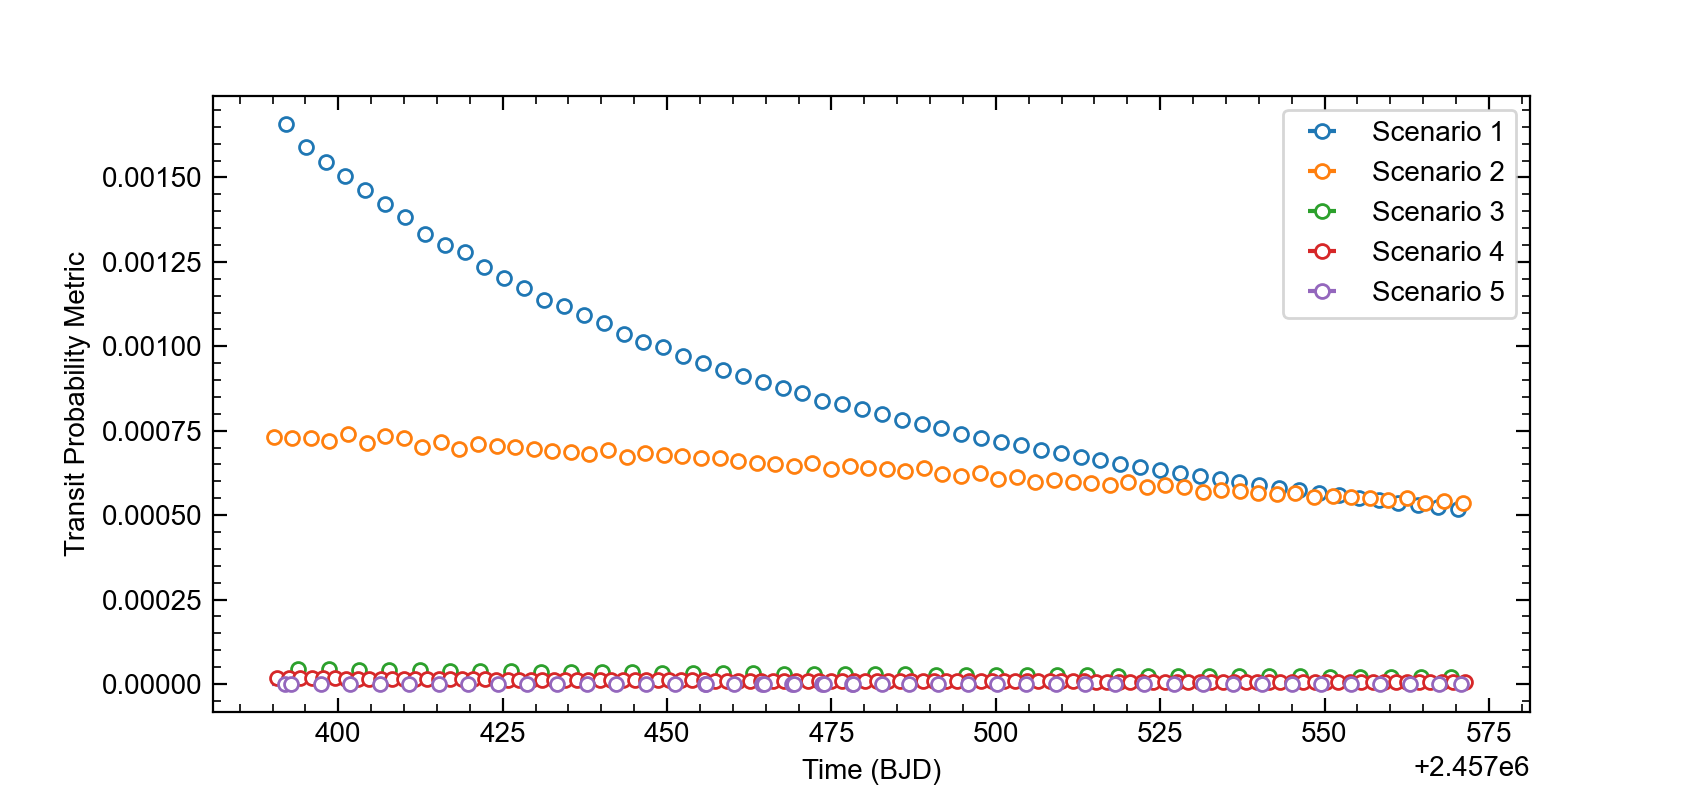

In [15]:
fig, ax = plt.subplots(figsize=(8.5, 4))

for i in np.unique(windows['scenario']):
    win = windows[windows['scenario'] == i]
    x = win['median'].jd
    y = win['tpm']
    xerr = [
        win['median'].jd-win['lower'].jd, 
        win['upper'].jd-win['median'].jd
    ]
    ax.errorbar(
        x, y, xerr=xerr, 
        ls='', marker='o', mfc='white', ms=5, label=f'Scenario {i}'
    )
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Transit Probability Metric');
ax.legend()

Scenarios 1 and 2 are definitely the most interesting to follow up, which makes sense because they were the first two signals identified by the TLS algorithm. The TPM for Scenario 1 degrades more quickly because it has a wide period posterior, causing the peaks in the transit prediction vector $\hat{\mathcal{T}}$ to get smeared out for most distant predictions.

## Identifying observable windows

Now let's see which of these will be observable from a given site (or list of sites, actually) using the `astroplan` package. To do so, we'll define our observing constraints, the sites, and the position of our object in the sky.

In [16]:
import astroplan as ap
from astropy.coordinates import SkyCoord
from astropy.time import Time

# Constraints
constraints = [
    ap.AtNightConstraint.twilight_civil(),
    ap.AltitudeConstraint(min=30.*units.deg),
    ap.MoonSeparationConstraint(min=30.*units.deg)
]

# Sites
sno = ap.Observer(
    longitude=-16.5097*units.deg, latitude=28.3*units.deg,
    elevation=2390*units.m, name='SNO', timezone='Atlantic/Canary'
)
sso = ap.Observer.at_site('Paranal')
saintex = ap.Observer.at_site(
    'Observatorio Astronomico Nacional, San Pedro Martir'
)
sites = [sno, sso, saintex]

# Target
target = ap.FixedTarget.from_name('TRAPPIST-1')

Now we'll identify the observable events for each site with `tf.observable_windows()`. This returns an `astropy.table.Table` with the scenario, tpm, and times and airmasses for the median transit prediction and the start and end of the observation, taking into account the 95% confidence interval for the prediction and the observing constraints.

In [17]:
obs_per_site = []
for site in sites:
    obs = tf.observable_windows(target, site, constraints, windows)
    obs_per_site.append(obs)
obs

<Table length=26>
scenario          tpm           ...       zmedian              zend       
                                ...                                       
 int64          float64         ...       float64            float64      
-------- ---------------------- ... ------------------- ------------------
       1  0.0006330778299686189 ...   2.217509232972463  1.724401177602187
       1  0.0006241985083190966 ...   1.744918717705431 1.6579018739987597
       1  0.0006150921039062755 ...  1.4856672818410597 1.5933215167355936
       1  0.0006063366649868624 ...  1.3379909678454962  1.536736916213004
       2   0.000536714312698208 ...  1.2360276013133307 1.2360084849046284
       4  7.110304587506045e-06 ...  2.0999738960466643  1.754927071958511
       4  6.899887063719424e-06 ...  1.6355683805965635 1.5948689052919416
       5 1.6849755067517347e-08 ...  -1.165067233731207 1.9954590819946305
       5 1.3515725160636625e-06 ...  -1.994409353386282 1.9951522912704018
     ...                    ... ...                 ...                ...
       5   4.43100195677749e-07 ... -1.1521030310912879 1.5744548851686007
       5  4.468495069871965e-07 ...   1.297425161715268 1.5034474826225246
       5  4.496740846835067e-07 ...  -1.202614815838914  1.427953364766218
       5 4.5327575690565044e-07 ...   1.393340432694066  1.432706372812361
       5   4.57066785392519e-07 ...  -1.297545667122127  1.326272714105996
       5 4.6318814092813337e-07 ...  1.4720808779976837 1.3078304485303855
       5 4.6974896445219397e-07 ...  -1.311379579642058  1.262630933244297
       5 4.7407042825794157e-07 ...  1.5184920450922499 1.2465312158057087
       5 3.8967259527380405e-07 ...  -1.498590125262575 1.2365903968739722
       5   2.52251222486276e-07 ... -2.8198824418520587  1.236649954567401

Let's visualize the results.

<IPython.core.display.Javascript object>


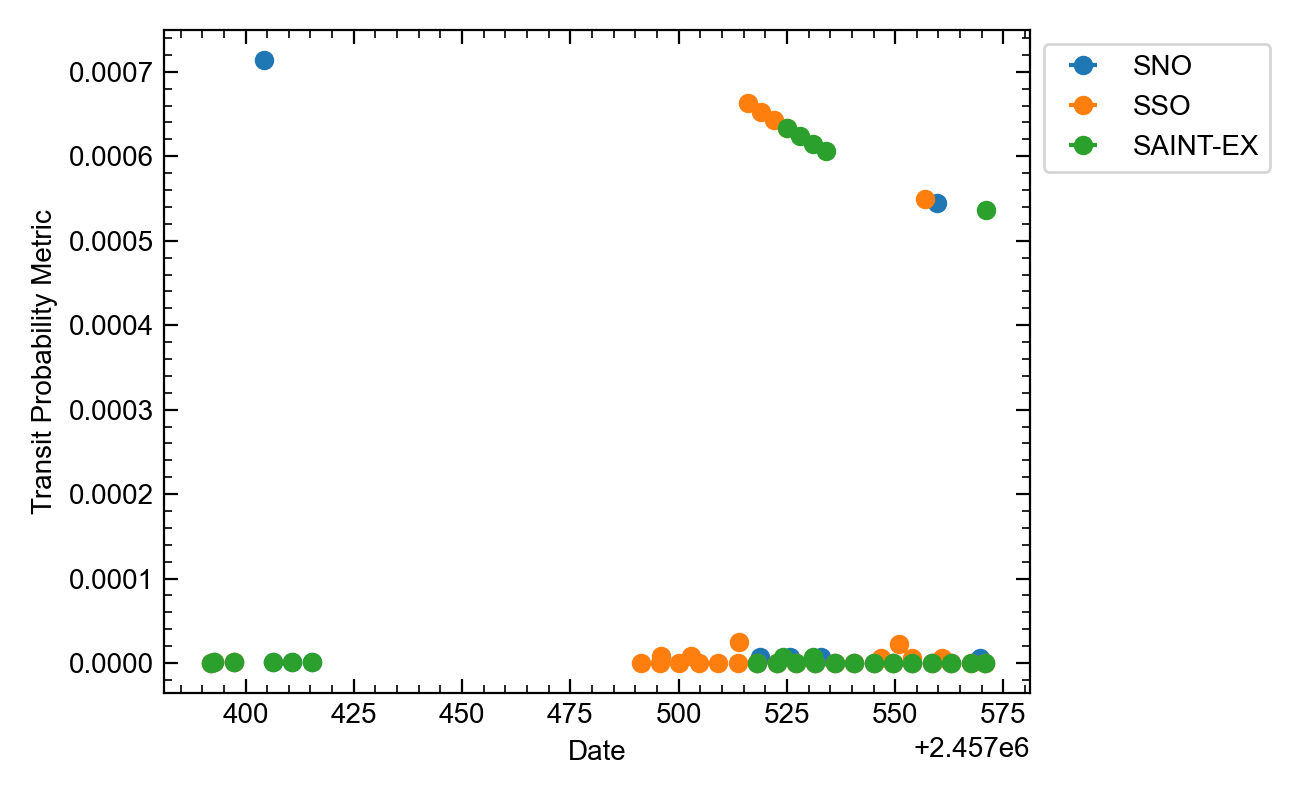

In [18]:
fig, ax = plt.subplots(figsize=(6.5, 4))

site_names = ['SNO', 'SSO', 'SAINT-EX']
for i, obs in enumerate(obs_per_site):
    pdobs = obs.to_pandas()
    ax.errorbar(
        obs['median'].jd, obs['tpm'], xerr=[obs['median'].jd-obs['start'].jd, obs['end'].jd-obs['median'].jd],
        ls='', marker='o', label=site_names[i], 
    )
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_xlabel('Date')
ax.set_ylabel('Transit Probability Metric')
plt.tight_layout()

Looks like there were a few high-TPM events (corresponding to Scenarios 1 and 2) and lots of low-TPM events that these faciltiies could have follow up in the first 6 months after the detection of TRAPPIST-1. The only problem is that none of them existed yet!